In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch: 0
Mean Train Loss: 4.00e-01
Mean Test Loss:  1.92e-01
Epoch: 10
Mean Train Loss: 1.53e-01
Mean Test Loss:  2.70e-01
Epoch: 20
Mean Train Loss: 1.08e-01
Mean Test Loss:  4.54e-01
Epoch: 30
Mean Train Loss: 7.23e-02
Mean Test Loss:  6.18e-01
Epoch: 40
Mean Train Loss: 5.58e-02
Mean Test Loss:  5.81e-01
Epoch: 50
Mean Train Loss: 3.82e-02
Mean Test Loss:  7.16e-01
Epoch: 60
Mean Train Loss: 2.91e-02
Mean Test Loss:  9.26e-01
Epoch: 70
Mean Train Loss: 2.55e-02
Mean Test Loss:  8.60e-01
Epoch: 80
Mean Train Loss: 2.01e-02
Mean Test Loss:  8.97e-01
Epoch: 90
Mean Train Loss: 1.61e-02
Mean Test Loss:  1.15e+00
Epoch: 100
Mean Train Loss: 7.30e-03
Mean Test Loss:  9.78e-01


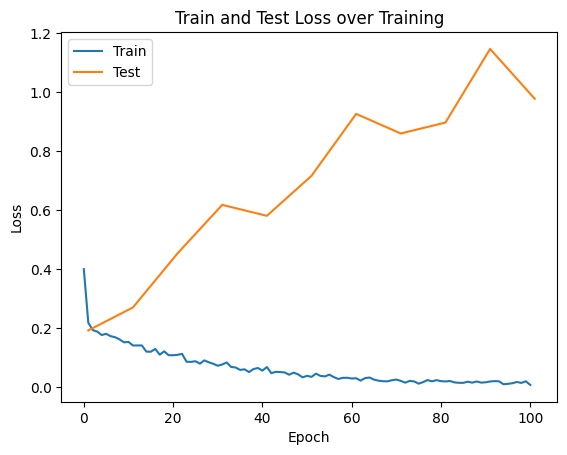

In [2]:
plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold">
    Good 👍
</div> 

# 2 Dropout
This method randomly switches neurons on and off for each layer. Since this is random a system is unliekly to memorize specific structures which would be connected to specific neurons. Therfore multiple neurons always need to be able to characterize an image, since some would be switched off. 

Epoch: 0
Mean Train Loss: 7.38e-01
Mean Test Loss:  4.84e-01
Epoch: 10
Mean Train Loss: 5.23e-01
Mean Test Loss:  5.50e-01
Epoch: 20
Mean Train Loss: 6.55e-01
Mean Test Loss:  6.67e-01
Epoch: 30
Mean Train Loss: 7.32e-01
Mean Test Loss:  7.07e-01
Epoch: 40
Mean Train Loss: 7.95e-01
Mean Test Loss:  7.75e-01
Epoch: 50
Mean Train Loss: 8.47e-01
Mean Test Loss:  1.02e+00
Epoch: 60
Mean Train Loss: 8.81e-01
Mean Test Loss:  8.53e-01
Epoch: 70
Mean Train Loss: 9.50e-01
Mean Test Loss:  9.99e-01
Epoch: 80
Mean Train Loss: 9.16e-01
Mean Test Loss:  9.74e-01
Epoch: 90
Mean Train Loss: 9.81e-01
Mean Test Loss:  1.01e+00
Epoch: 100
Mean Train Loss: 1.02e+00
Mean Test Loss:  1.19e+00


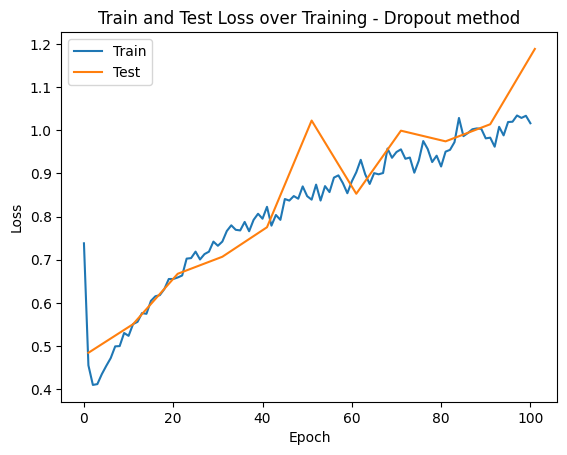

In [9]:
def dropout(X,p_drop=0.5):
    if p_drop>0 and p_drop<1:
        phi = np.random.binomial(n=1, p=p_drop, size=X.shape)
        phi = torch.tensor(phi, dtype=X.dtype)

        phimask= ~(phi==1)
        X[phimask]= (X[phimask]/(1-phi[phimask]))
        X[~phimask]=0
        return X
    else:
        return X
mydropprob=0.5
def dropout_model (X , w_h , w_h2 , w_o , p_drop_input , p_drop_hidden ) :
    x=dropout(X,p_drop_input)
    H = rectify(x @ w_h)
    h=dropout(H,p_drop_hidden)
    H2 = rectify(h @ w_h2)
    h2=dropout(H2,p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))trainX = trainX . reshape ( -1 , 1 , 28 , 28) # training data
testX = testX . reshape ( -1 , 1 , 28 , 28) # test data
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input=mydropprob , p_drop_hidden=mydropprob)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input=mydropprob , p_drop_hidden=mydropprob)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training - Dropout method")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()<

<div style="color: green; font-weight: bold">
    Also good 👍. Pretty much identical to the sample solution. In my opinion, the dropout function could be defined directly way better with torch.rand, because that way there's no back and forth between numpy and pytorch, since torch tensors don't like numpy methods.
</div> 

 In the data we see that the loss increases similarly for train and test data during sampling. It is a good result that both test and train data show similar performance, showing that there is no overfitting. Nonethelss the increase of the Loss is something uinwanted. THis could most likely be avoided by choosing lower dropout probabilities.
 As running this takes some time this is not tried.

# 3 Parametric ReLu
We were unsure if we should replace the rectify layers by the PRelu, which is what we did in the following

Epoch: 0
Mean Train Loss: 7.56e-01
Mean Test Loss:  4.83e-01
Epoch: 10
Mean Train Loss: 3.29e-01
Mean Test Loss:  3.32e-01
Epoch: 20
Mean Train Loss: 2.91e-01
Mean Test Loss:  2.98e-01
Epoch: 30
Mean Train Loss: 2.78e-01
Mean Test Loss:  2.90e-01
Epoch: 40
Mean Train Loss: 2.69e-01
Mean Test Loss:  2.83e-01
Epoch: 50
Mean Train Loss: 2.67e-01
Mean Test Loss:  2.68e-01
Epoch: 60
Mean Train Loss: 2.61e-01
Mean Test Loss:  2.78e-01
Epoch: 70
Mean Train Loss: 2.56e-01
Mean Test Loss:  2.74e-01
Epoch: 80
Mean Train Loss: 2.50e-01
Mean Test Loss:  2.66e-01
Epoch: 90
Mean Train Loss: 2.49e-01
Mean Test Loss:  2.61e-01
Epoch: 100
Mean Train Loss: 2.49e-01
Mean Test Loss:  2.74e-01


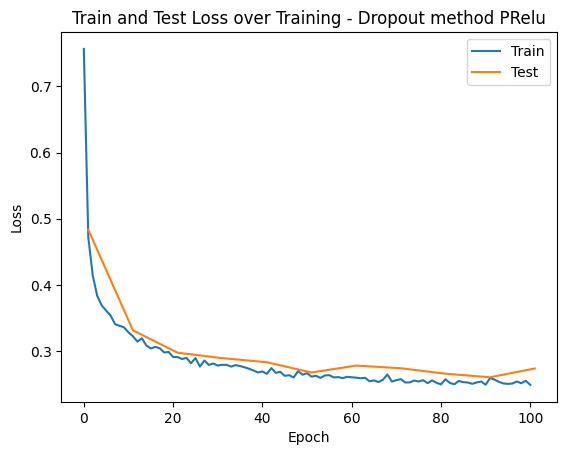

In [13]:
def PRelu(x,a):
    # Rectified Linear Unit (ReLU)
    rect=torch.max(torch.zeros_like(x), x)
    rect[rect==0] = x[rect==0]*a[rect==0]
    return rect

def PReludropout_model (X , w_h , w_h2 , w_o ,a_input, a_hidden, p_drop_input , p_drop_hidden ) :
    x=dropout(X,p_drop_input)
    H = PRelu(x @ w_h,a_input)
    h=dropout(H,p_drop_hidden)
    H2 = PRelu(h @ w_h2,a_hidden)
    h2=dropout(H2,p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
a_in=init_weights((100, 625))
a_hid=init_weights((100, 625))Skip to main panel
>
/Desktop/
Name
Modified

Selection deleted
from torch.nn.functional import conv2d , max_pool2d

<function torch.nn.functional.boolean_dispatch.<locals>.fn(*args, **kwargs)>

Selection deleted

torch.Size([1, 28, 28])

Selection deleted
def PRelu(x,a):
    # Rectified Linear Unit (ReLU)
    rect=torch.max(torch.zeros_like(x), x)
    rect[rect==0] = x[rect==0]*a[rect==0]
    return rect

def ConVPReludropout_model (X , w_c1,w_c2,w_c3 , w_h2 , w_o , p_drop_input , p_drop_hidden ) :
    x=dropout(X,p_drop_input)



    ###1st convolutionional layer
    convolutional_layer = rectify( conv2d ( x , w_c1 ) )
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer = max_pool2d( convolutional_layer , (2 , 2) )
    out_layer = dropout( subsampling_layer , p_drop_input )
    
    ###2nd convolutionional layer
    convolutional_layer = rectify( conv2d ( out_layer , w_c2 ) )
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer = max_pool2d( convolutional_layer , (2 , 2) )
    out_layer = dropout( subsampling_layer , p_drop_input )
    
    ###3rd convolutionional layer
    convolutional_layer = rectify( conv2d ( out_layer , w_c3 ) )
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer = max_pool2d( convolutional_layer , (2 , 2) )
    out_layer = dropout( subsampling_layer , p_drop_input )
    h=torch.reshape(out_layer, (1 ,out_layer.shape[0]*out_layer.shape[1]))
    




    
    
    H2 = rectify(h @ w_h2)
    h2=dropout(H2,p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax
# initialize weights

# input shape is (B, 784)
w_c1= init_weights((32,1,5,5))
w_c2= init_weights((64,32,5,5))
w_c3= init_weights((128,64,3,3))


# hidden layer with 625 neurons
w_h2 = init_weights(( int(784/(3*4)), 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_c1,w_c2,w_c3, w_h2, w_o])


n_epochs = 10

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires an Image input
        #x = x.reshape(batch_size, 784)
        x = x.reshape( -1 , 1 , 28 , 28) 
        
        # feed input through model
        noise_py_x = ConVPReludropout_model(x, w_c1,w_c2,w_c3, w_h2, w_o, p_drop_input=mydropprob , p_drop_hidden=mydropprob)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape( -1 , 1 , 28 , 28) 
        
                noise_py_x = ConVPReludropout_model(x, w_c1,w_c2,w_c3, w_h2, w_o, p_drop_input=mydropprob , p_drop_hidden=mydropprob)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training - Convolutional Net")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
Cell In[35], line 74
     71 x = x.reshape( -1 , 1 , 28 , 28) 
     73 # feed input through model
---> 74 noise_py_x = ConVPReludropout_model(x, w_c1,w_c2,w_c3, w_h2, w_o, p_drop_input=mydropprob , p_drop_hidden=mydropprob)
     76 # reset the gradient
     77 optimizer.zero_grad()

Cell In[35], line 29, in ConVPReludropout_model(X, w_c1, w_c2, w_c3, w_h2, w_o, p_drop_input, p_drop_hidden)
     27 subsampling_layer = max_pool2d( convolutional_layer , (2 , 2) )
     28 out_layer = dropout( subsampling_layer , p_drop_input )
---> 29 h=torch.reshape(out_layer, (1 ,out_layer.shape[1]*out_layer.shape[2]))
     37 H2 = rectify(h @ w_h2)
     38 h2=dropout(H2,p_drop_hidden)

RuntimeError: shape '[1, 128]' is invalid for input of size 12800

%debug

> /tmp/ipykernel_12247/2476888887.py(29)ConVPReludropout_model()
     27     subsampling_layer = max_pool2d( convolutional_layer , (2 , 2) )
     28     out_layer = dropout( subsampling_layer , p_drop_input )
---> 29     h=torch.reshape(out_layer, (1 ,out_layer.shape[1]*out_layer.shape[2]))
     30 
     31 

ipdb>  out_layer.shape

torch.Size([100, 128, 1, 1
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o,a_in,a_hid])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = PReludropout_model(x, w_h, w_h2, w_o,a_in,a_hid, p_drop_input=mydropprob , p_drop_hidden=mydropprob)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = PReludropout_model(x, w_h, w_h2, w_o, a_in, a_hid, p_drop_input=mydropprob , p_drop_hidden=mydropprob)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training - Dropout method PRelu")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold">
    Although your code shows some errors up there, your solution seems pretty close to the sample solution. Your implementation for the parametric / dropout model is good.
</div> 

This time we see that the 'learned' relu function lead to a reduction in the loss and therefore improved the overall result. Furthermore train and test lines concurr showing that the data is not overfit

# 4 Convolutional layers
 as the inclusion of the PRelu is more computationally expnsive, we will not include it

In [34]:
from torch.nn.functional import conv2d , max_pool2d


<function torch.nn.functional.boolean_dispatch.<locals>.fn(*args, **kwargs)>

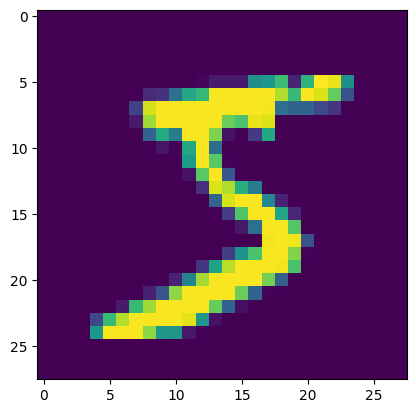

In [19]:
plt.imshow(train_dataset.data[0])
plt.show()

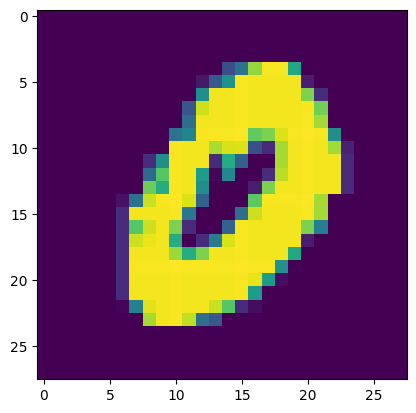

In [26]:
'''for idx, batch in enumerate(train_dataloader):
        trainX, trainy = batch
trainX = trainX.reshape( -1 , 1 , 28 , 28) # training data
#testX = testX.reshape ( -1 , 1 , 28 , 28) # test data
'''
plt.imshow(trainX[0][0,:])
plt.show()

<div style="color: green; font-weight: bold">
    You should explain why you are showing these images, just a short comment would suffice
</div> 

Epoch: 0
Mean Train Loss: 2.02e+00
Mean Test Loss:  1.25e+00
Epoch: 10
Mean Train Loss: 4.10e-01
Mean Test Loss:  3.73e-01
Epoch: 20
Mean Train Loss: 4.38e-01
Mean Test Loss:  3.90e-01
Epoch: 30
Mean Train Loss: 5.40e-01
Mean Test Loss:  6.71e-01
Epoch: 40
Mean Train Loss: 6.43e-01
Mean Test Loss:  7.13e-01
Epoch: 50
Mean Train Loss: 7.26e-01
Mean Test Loss:  7.18e-01
Epoch: 60
Mean Train Loss: 8.27e-01
Mean Test Loss:  7.96e-01
Epoch: 70
Mean Train Loss: 9.13e-01
Mean Test Loss:  7.98e-01
Epoch: 80
Mean Train Loss: 9.80e-01
Mean Test Loss:  8.31e-01
Epoch: 90
Mean Train Loss: 1.04e+00
Mean Test Loss:  9.30e-01
Epoch: 100
Mean Train Loss: 1.06e+00
Mean Test Loss:  9.91e-01


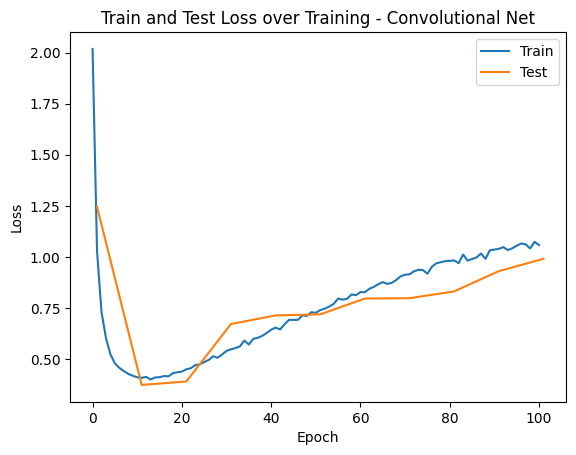

In [73]:
def PRelu(x,a):
    # Rectified Linear Unit (ReLU)
    rect=torch.max(torch.zeros_like(x), x)
    rect[rect==0] = x[rect==0]*a[rect==0]
    return rect

def ConVPReludropout_model (X , w_c1,w_c2,w_c3 , w_h2 , w_o , p_drop_input , p_drop_hidden ) :
    x=dropout(X,p_drop_input)



    ###1st convolutionional layer
    convolutional_layer = rectify( conv2d( x , w_c1 ) )
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer = max_pool2d( convolutional_layer , (2 , 2) )
    out_layer = dropout( subsampling_layer , p_drop_input )
    
    ###2nd convolutionional layer
    convolutional_layer = rectify( conv2d( out_layer , w_c2 ) )
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer = max_pool2d( convolutional_layer , (2 , 2) )
    out_layer = dropout( subsampling_layer , p_drop_input )
    
    ###3rd convolutionional layer
    convolutional_layer = rectify( conv2d( out_layer , w_c3 ) )
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer = max_pool2d( convolutional_layer , (2 , 2) )
    out_layer = dropout( subsampling_layer , p_drop_input )
    hi=torch.reshape(out_layer, (out_layer.shape[0],out_layer.shape[1]))
    




    
    
    H2 = rectify(hi @ w_h2)
    h2=dropout(H2,p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax
# initialize weights

# input shape is (B, 784)
w_c1= init_weights((32,1,5,5))
w_c2= init_weights((64,32,5,5))
w_c3= init_weights((128,64,3,3))


# hidden layer with 625 neurons
w_h2 = init_weights((128, 625)) # since I have 128 output images/filters I want to connect each to all 625 neurons
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_c1,w_c2,w_c3, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        xorig, y = batch

        # our model requires an Image input
        #x = x.reshape(batch_size, 784)
        x = xorig.reshape( -1 , 1 , 28 , 28) 
        
        # feed input through model
        noise_py_x = ConVPReludropout_model(x, w_c1,w_c2,w_c3, w_h2, w_o, p_drop_input=mydropprob , p_drop_hidden=mydropprob)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Ethepoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                xorig, y = batch
                x = xorig.reshape( -1 , 1 , 28 , 28) 
        
                noise_py_x = ConVPReludropout_model(x, w_c1,w_c2,w_c3, w_h2, w_o, p_drop_input=mydropprob , p_drop_hidden=mydropprob)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training - Convolutional Net")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold">
    It is not easy to overlook the results when all coding is done in only one codingblock, but the network is very well implemented.
    The training and testing did not have to be done right away, but the results are a nice check and seem reasonable.
    Also please rename variables, that are different but have the same name.
</div> 

We still see that test and training sets have similar loss levels showing moderate avoidance of overfitting. None the less we see high loss levels than for the PReLu from before.
In the next cell we plot an example from the test set, as well as its convolutions, without droput probability for each layer of the convolution after subsampling.
Then we also depict the corresponding filter weights.

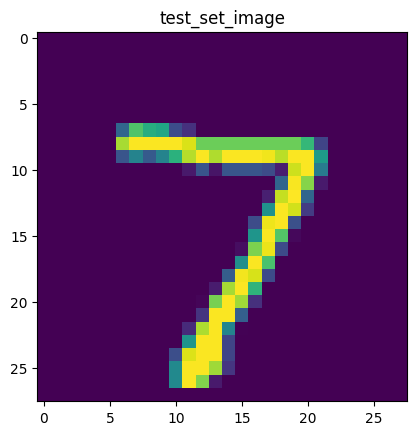

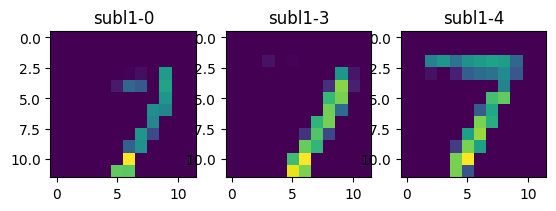

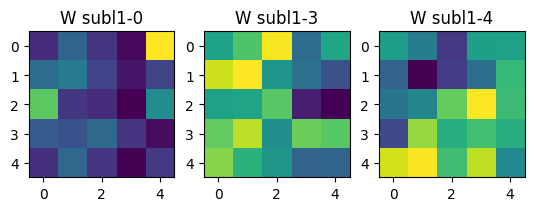

In [74]:
def ConVPReludropout_modelforImages(X , w_c1,w_c2,w_c3 , w_h2 , w_o , p_drop_input , p_drop_hidden ) :
    x=dropout(X,p_drop_input)



    ###1st convolutionional layer
    convolutional_layer = rectify( conv2d( x , w_c1 ) )
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer1 = max_pool2d( convolutional_layer , (2 , 2) )
    out_layer1 = dropout( subsampling_layer1 , p_drop_input )
    
    ###2nd convolutionional layer
    convolutional_layer = rectify( conv2d( out_layer1 , w_c2 ) )
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer2 = max_pool2d( convolutional_layer , (2 , 2) )
    out_layer2 = dropout( subsampling_layer2 , p_drop_input )
    
    ###3rd convolutionional layer
    convolutional_layer = rectify( conv2d( out_layer2 , w_c3 ) )
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer3 = max_pool2d( convolutional_layer , (2 , 2) )
    out_layer3 = dropout( subsampling_layer3 , p_drop_input )
    hi=torch.reshape(out_layer3, (out_layer3.shape[0],out_layer3.shape[1]))
    




    
    
    H2 = rectify(hi @ w_h2)
    h2=dropout(H2,p_drop_hidden)
    pre_softmax = h2 @ w_o
    return(subsampling_layer1,subsampling_layer2,subsampling_layer3)
    #return(out_layer1,out_layer2,out_layer3)
# plot test set image
for idx, batch in enumerate(test_dataloader):
    xorig, y = batch
    x = xorig.reshape( -1 , 1 , 28 , 28) 
            
    plt.title('test_set_image')
    plt.imshow(x[0][0,:])
    plt.show()
    o1,o2,o3 = ConVPReludropout_modelforImages(x, w_c1,w_c2,w_c3, w_h2, w_o, p_drop_input=0 , p_drop_hidden=0)
    break
plt.figure()
ax=plt.subplot(1,3,1)
plt.title('subl1-0')
ax.imshow(o1[0][0].detach())
ax2=plt.subplot(1,3,2)
plt.title('subl1-3')
ax2.imshow(o1[0][3].detach())
ax3=plt.subplot(1,3,3)
plt.title('subl1-4')
ax3.imshow(o1[0][4].detach())
plt.show()

plt.figure()
ax=plt.subplot(1,3,1)
plt.title('W subl1-0')
ax.imshow(w_c1[0,0,:].detach())
ax2=plt.subplot(1,3,2)
plt.title('W subl1-3')
ax2.imshow(w_c1[3,0,:].detach())
ax3=plt.subplot(1,3,3)
plt.title('W subl1-4')
ax3.imshow(w_c1[4,0,:].detach())
plt.show()


<div style="color: green; font-weight: bold">
    Again if i would complain, than about the naming of the variables and plots, but the code is nice and the results seem reasonable.
    Also a further expletnation of your results is laking.
</div> 

# 3.2


![alt text](MLHW3Sketch.PNG 'title')



Furthermore we include a random linear shift on the training data and see if it reduces overfitting

Epoch: 0
Mean Train Loss: 2.12e+00
Mean Test Loss:  1.33e+00
Epoch: 10
Mean Train Loss: 5.20e-01
Mean Test Loss:  4.57e-01
Epoch: 20
Mean Train Loss: 5.33e-01
Mean Test Loss:  4.27e-01
Epoch: 30
Mean Train Loss: 6.14e-01
Mean Test Loss:  5.10e-01
Epoch: 40
Mean Train Loss: 7.05e-01
Mean Test Loss:  7.31e-01
Epoch: 50
Mean Train Loss: 7.75e-01
Mean Test Loss:  6.14e-01
Epoch: 60
Mean Train Loss: 8.48e-01
Mean Test Loss:  6.28e-01
Epoch: 70
Mean Train Loss: 9.06e-01
Mean Test Loss:  1.08e+00
Epoch: 80
Mean Train Loss: 9.64e-01
Mean Test Loss:  7.94e-01
Epoch: 90
Mean Train Loss: 1.02e+00
Mean Test Loss:  7.94e-01
Epoch: 100
Mean Train Loss: 1.09e+00
Mean Test Loss:  1.04e+00


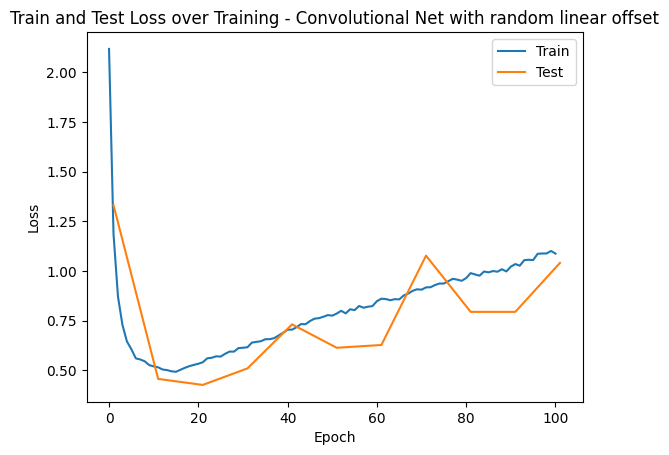

In [83]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# input shape is (B, 784)
w_c1= init_weights((32,1,5,5))
w_c2= init_weights((64,32,5,5))
w_c3= init_weights((128,64,3,3))


# hidden layer with 625 neurons
w_h2 = init_weights((128, 625)) # since I have 128 output images/filters I want to connect each to all 625 neurons
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_c1,w_c2,w_c3, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        xorig, y = batch

        ################################
        # ad a liniear offset that can be as large as 75% of the brightes pixel in the data
        maxpxval=torch.max(xorig)
        #xorig =xorig + torch.randn(size=(xorig.shape[0],1))*maxpxval *3/4 *torch.ones_like(xorig[0]) 
        #random offsets between -3/4 and 3/4 of the maximum px val
        offsets = torch.rand(size=(xorig.shape[0], 1, 28, 28)) * maxpxval * 3/2 - maxpxval * 3/4
        xorig += offsets #upon reconsiderations this probably has random offsets on all pixels and not one per frame. This is why it does not help... Since it takes ages to run I wont change this now
        ######################
        
        # our model requires an Image input
        #x = x.reshape(batch_size, 784)
        x = xorig.reshape( -1 , 1 , 28 , 28) 
        
        # feed input through model
        noise_py_x = ConVPReludropout_model(x, w_c1,w_c2,w_c3, w_h2, w_o, p_drop_input=mydropprob , p_drop_hidden=mydropprob)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                xorig, y = batch
                x = xorig.reshape( -1 , 1 , 28 , 28) 
        
                noise_py_x = ConVPReludropout_model(x, w_c1,w_c2,w_c3, w_h2, w_o, p_drop_input=mydropprob , p_drop_hidden=mydropprob)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training - Convolutional Net with random linear offset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#### what we see is that with the linear offsets the Loss is of similar size, but the test set loss is closer to the training set loss, implying less overfitting of the training set. Nonetheless there is not much improvement

<div style="color: green; font-weight: bold">
    Good!
    As mentioned a further explenation of the results can be beneficial.
</div> 